# Data loading

In [1]:
import pandas as pd
import numpy as np
import os
working_directory = os.getcwd()
print(working_directory)

/Users/selesselvan/Documents/DPS


In [2]:
import chardet
def get_file_encoding(file_name):
    with open(file=file_name, mode='rb') as inp:
        encoding= chardet.detect(inp.read(10000))['encoding']
    return encoding

In [51]:
file_path = './220511_monatszahlenmonatszahlen2204_verkehrsunfaelle.csv'

In [86]:
df = pd.read_csv(file_path, sep=',', encoding=get_file_encoding(file_path))

In [5]:
df.shape

(2086, 9)

# EDA

In [7]:
df.head(5)

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2022,202201,NaN,16.0,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2022,202202,NaN,14.0,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2022,202203,NaN,24.0,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2022,202204,NaN,16.0,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2022,202205,NaN,24.0,NaN,NaN,NaN


In [8]:
df.columns

Index(['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT', 'VORJAHRESWERT',
       'VERAEND_VORMONAT_PROZENT', 'VERAEND_VORJAHRESMONAT_PROZENT',
       'ZWOELF_MONATE_MITTELWERT'],
      dtype='object')

In [9]:
df.MONATSZAHL.unique()

array(['Alkoholunfälle', 'Fluchtunfälle', 'Verkehrsunfälle'], dtype=object)

In [10]:
df.AUSPRAEGUNG.unique()

array(['insgesamt', 'Verletzte und Getötete', 'mit Personenschäden'],
      dtype=object)

In [12]:
df.JAHR.nunique()

23

In [14]:
df.MONAT.nunique()

277

In [16]:
df.WERT.isna().sum()

84

In [17]:
df[df.MONAT == 'Summe'].shape

(154, 9)

# Data Pre-Processing

In [87]:
df = df[['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT']]

In [88]:
df.isna().sum()

MONATSZAHL      0
AUSPRAEGUNG     0
JAHR            0
MONAT           0
WERT           84
dtype: int64

In [92]:
df.dropna(inplace=True)

In [82]:
df.shape

(2002, 5)

In [90]:
df = df[(df.MONATSZAHL == 'Alkoholunfälle') & (df.AUSPRAEGUNG == 'insgesamt')]

In [91]:
df = df[df.MONAT != 'Summe']

In [94]:
from tqdm import tqdm
tqdm.pandas()

def split_month(monat_entry):
    _, month_field = monat_entry[0:4], monat_entry[4:]
    return pd.Series([month_field])

df[['MONAT']] = df.MONAT.progress_apply(split_month)

100%|██████████| 264/264 [00:00<00:00, 13877.28it/s]


In [95]:
df.head(5)

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
13,Alkoholunfälle,insgesamt,2021,01,16.0
14,Alkoholunfälle,insgesamt,2021,02,14.0
15,Alkoholunfälle,insgesamt,2021,03,24.0
16,Alkoholunfälle,insgesamt,2021,04,16.0
17,Alkoholunfälle,insgesamt,2021,05,24.0


In [96]:
working_df = df[df.JAHR <= 2020]
ground_truth_df = df[df.JAHR > 2020]
working_df.shape, ground_truth_df.shape

((252, 5), (12, 5))

# Visualization

# Statistical Testing

In [97]:
from statsmodels.tsa.stattools import adfuller
adft = adfuller(df[['WERT']],autolag="AIC")

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

       Values                       Metric
0    1.670824              Test Statistics
1    0.998055                      p-value
2   11.000000             No. of lags used
3  252.000000  Number of observations used
4   -3.456569          critical value (1%)
5   -2.873079          critical value (5%)
6   -2.572919         critical value (10%)


We can see that our data is not stationary from the fact that our p-value is greater than 5 percent and the test statistic is greater than the critical value. We can also draw these conclusions from inspecting the data, as we see a clear, increasing trend in the WERT.

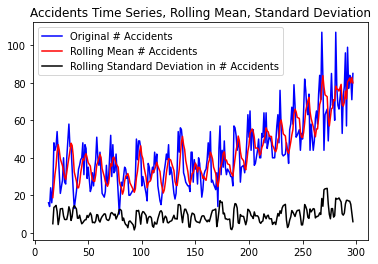

In [107]:
import matplotlib.pyplot as plt


rolling_mean = df[['WERT']].rolling(5).mean()
rolling_std = df[['WERT']].rolling(5).std()
plt.plot(df[['WERT']], color="blue",label="Original # Accidents")
plt.plot(rolling_mean, color="red", label="Rolling Mean # Accidents")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in # Accidents")
plt.title("Accidents Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

# Statistical Modeling

# Machine Learning Model for prediction

# Generalization Error with Ground Truth Data